# Otimização da Rota em Hollow Knight

Minimizar a distância total percorrida para zerar o jogo, respeitando pré‑requisitos de poderes.


## 1. Introdução

A ideia desse trabalho surgiu com a ideia de otimizar algo de minha vida: com o recente lançamento do jogo Hollow Knight: Silksong, lembrei-me que eu ainda não tinha platinado todas as conquistas do jogo anterior, Hollow Knight. Uma dessas conquistas inclui zerar o jogo em menos de 5hs, assim, pensei que se adequaria a esse trabalho de otimização buscar a menor rota em distância que eu teria que fazer dentro do jogo para zerá-lo rapidamente.

Falando sobre o jogo, para zerá-lo, é necessário que o jogador pegue as 3 Máscaras dos Sonhadores e em seguida vá para a área do Boss final. Porém, para conseguir avançar pelo mapa (e com isso pegar as 3 máscaras dos sonhadores), o jogador precisa pegar uma série de poderes. Vale notar que alguns poderes são necessários para pegar outros poderes, por exemplo, para pegar a Segunda Máscara do Sonhador, o jogador precisa do poder Manto Sombrio ou Lágrima de Isma, sendo que ambos precisam do poder Coração de Cristal para serem pegos.

É nesse contexto que surge o meu trabalho, no qual eu quero pegar a menor rota para zerar o jogo e considerando essa ordem em que os poderes devem ser pegos. Vale notar que não existe uma ordem obrigatória e definida, o jogador pode pegar qualquer poder acessível a ele na ordem que ele quiser: e quando ele pega tal poder, novos caminhos são abertos a ele, característica de um jogo aberto como é Hollow Knight. 

Nesse sentido, esse trabalho se assemelha um pouco ao Problema do Caixeiro Viajante com Precedência (PCV-RP), no qual temos alguns vértices que devem ser passados apenas uma vez (em nosso caso serão os poderes) e existe uma certa precedência no qual os vértices são visitados (ordem dos poderes). As aplicações para esse problema do PCV-RP na vida real são diversas, tal como em logísticas (pontos de coleta e entrega, deve-se passar no local de coleta antes do local da entrega) ou no turismo (itinerários perosnalizados em que se deve passar em pontos turísticos antes de outros).

Observações: para meu problema, eu assumo que a gameplay é feita em Modo Alma de Aço, ou seja, o personagem não pode morrer senão o jogo acaba. Isso porque no modo normal do jogo, a morte do personagem o leva ao seu último ponto de checkpoint, o que seria equivalente a teleportar no mapa, e isso tornaria a modelagem do problema ainda mais complicada.

## 2. Coleta de dados

A coleta de dados do mapa do jogo (para compor o grafo) foi feita manualmente, na qual eu joguei o jogo Hollow Knight seguindo sua progressão normal e, por meio do site Geogebra (https://www.geogebra.org/classic), fui definindo cada ponto do grafo em cima da imagem do mapa do jogo e anotando caso houvesse algum requisito para utilizar uma aresta. Essa gameplay rendeu um save de 9hs no qual fui cartógrafo. Com isso, consegui o arquivo "mapa.ggb".

Em seguida, converti os dados da estrutura de "mapa.ggb" para arquivo csv usando o próprio site do Geogebra Classic. O arquivo gerado, "mapa.csv" possui todos os pontos e arestas juntos no mesmo arquivo, dessa forma, abaixo está o código para separar esse arquivo em dois csvs separados, um contendo apenas pontos e outro contendo apenas os segmentos.

In [90]:
# Importação das bibliotecas
import re
import math
import csv
from pathlib import Path

import pandas as pd
import networkx as nx
import pyomo.environ as pyo

from IPython.display import Image, display
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from matplotlib.lines import Line2D

In [91]:
# Lê mapa.csv com 3 colunas (separador padrão do Excel/Geogebra é tab)
mapa_df = pd.read_csv("mapa.csv", header=None, dtype=str, sep="\t").fillna("")
mapa_df = mapa_df.iloc[:, :3]
mapa_df.columns = ["tipo", "expr", "extra"]

print("Primeiras linhas de mapa.csv:")
display(mapa_df.head(10))

pontos = []
segmentos = []

for _, row in mapa_df.iterrows():
    tipo = row["tipo"].strip()
    expr = row["expr"].strip()
    extra = row["extra"].strip()

    # ----- PONTOS -----
    # Agora sempre pegamos name, x, y da coluna 'extra',
    # que vem no formato:  "C = (240.4, 349.2)"
    if tipo.startswith("Ponto") and "Segmento" not in tipo:
        m_extra = re.search(r"([A-Za-z0-9_]+)\s*=\s*\(([^,]+),\s*([^)]+)\)", extra)
        if not m_extra:
            # se por algum motivo vier em expr, tenta lá também
            m_extra = re.search(r"([A-Za-z0-9_]+)\s*=\s*\(([^,]+),\s*([^)]+)\)", expr)
        if not m_extra:
            continue
        name = m_extra.group(1).strip()
        x = float(m_extra.group(2).replace(",", ".").strip())
        y = float(m_extra.group(3).replace(",", ".").strip())
        pontos.append({"name": name, "x": x, "y": y})

    # ----- SEGMENTOS -----
    # Exemplo: tipo = "Segmento f", expr = "Segmento(C, D)", extra = "f = 28.2"
    elif tipo.startswith("Segmento"):
        # nome do segmento (tudo depois de "Segmento ")
        m_seg = re.match(r"Segmento\s+(.+)", tipo)
        if not m_seg:
            continue
        seg_name = m_seg.group(1).strip()

        # nós início/fim em expr: Segmento(C, D)
        m_nodes = re.search(r"Segmento\(([^,]+),\s*([^)]+)\)", expr)
        if not m_nodes:
            continue
        start = m_nodes.group(1).strip()
        end = m_nodes.group(2).strip()

        # comprimento em extra: "f = 28.2"
        m_len = re.search(r"=\s*([\d.,]+)", extra)
        if not m_len:
            continue
        length_str = m_len.group(1).replace(",", ".").strip()
        try:
            length = float(length_str)
        except ValueError:
            continue

        segmentos.append({
            "name": seg_name,
            "start": start,
            "end": end,
            "length": length
        })

# Monta dataframes finais
pontos_df = pd.DataFrame(pontos).drop_duplicates().reset_index(drop=True)
segmentos_df = pd.DataFrame(segmentos).drop_duplicates().reset_index(drop=True)

# Salva com os nomes que você quer
pontos_df.to_csv("pontos.csv", index=False)
segmentos_df.to_csv("segmentos.csv", index=False)

print("pontos.csv criado com", len(pontos_df), "linhas")
print("segmentos.csv criado com", len(segmentos_df), "linhas")
display(pontos_df.head(10))
display(segmentos_df.head(10))

Primeiras linhas de mapa.csv:


tipo                expr                      extra
0     Ponto START                         START = (240.4, 349.2)
1         Ponto D                             D = (268.6, 347.3)
2         Ponto E                             E = (263.4, 352.4)
3         Ponto F                             F = (251.1, 361.3)
4         Ponto G                             G = (282.4, 361.5)
5      Segmento f  Segmento(START, D)                   f = 28.2
6      Segmento g      Segmento(D, E)                    g = 7.3
7      Segmento i      Segmento(F, G)                   i = 31.4
8  Ponto Estacao2                      Estacao2 = (326.3, 353.1)
9         Ponto J                             J = (326.2, 340.2)

pontos.csv criado com 448 linhas
segmentos.csv criado com 524 linhas


name      x      y
0     START  240.4  349.2
1         D  268.6  347.3
2         E  263.4  352.4
3         F  251.1  361.3
4         G  282.4  361.5
5  Estacao2  326.3  353.1
6         J  326.2  340.2
7        K8  308.5  340.4
8        L7  308.5  322.1
9         M  320.3  315.2

name  start         end  length
0    f  START           D    28.2
1    g      D           E     7.3
2    i      F           G    31.4
3    l      J    Estacao2    12.9
4    m      J          K8    17.7
5    n     K8          L7    18.3
6    p     N2  AlavancaC1    61.0
7    q     K8          N2    10.7
8    r     N2          L7    10.3
9    a      Q          K8    11.6

Abaixo está o código que, a partir dos csvs dos pontos e segmentos, gera a imagem do grafo do mapa para visualização. São geradas duas imagens, uma com o grafo puro, chamado "mapa_plot", e a segunda com o grafo em cima da imagem do mapa do jogo, com o nome "mapa_plot_bg". O código abaixo é ignorável e serve só para visualização do grafo

Imagem salva em: c:\Users\guilh\OneDrive\Faculdade\FACULDADE\6° período\OTM\Trab\mapa_plot.png
Pontos lidos: 448
Segmentos lidos: 524
Todos os pontos referenciados em segmentos foram encontrados.
Pronto.
Imagem com fundo salva em: c:\Users\guilh\OneDrive\Faculdade\FACULDADE\6° período\OTM\Trab\mapa_plot_bg.png
Imagem com fundo salva em: c:\Users\guilh\OneDrive\Faculdade\FACULDADE\6° período\OTM\Trab\mapa_plot_bg.png


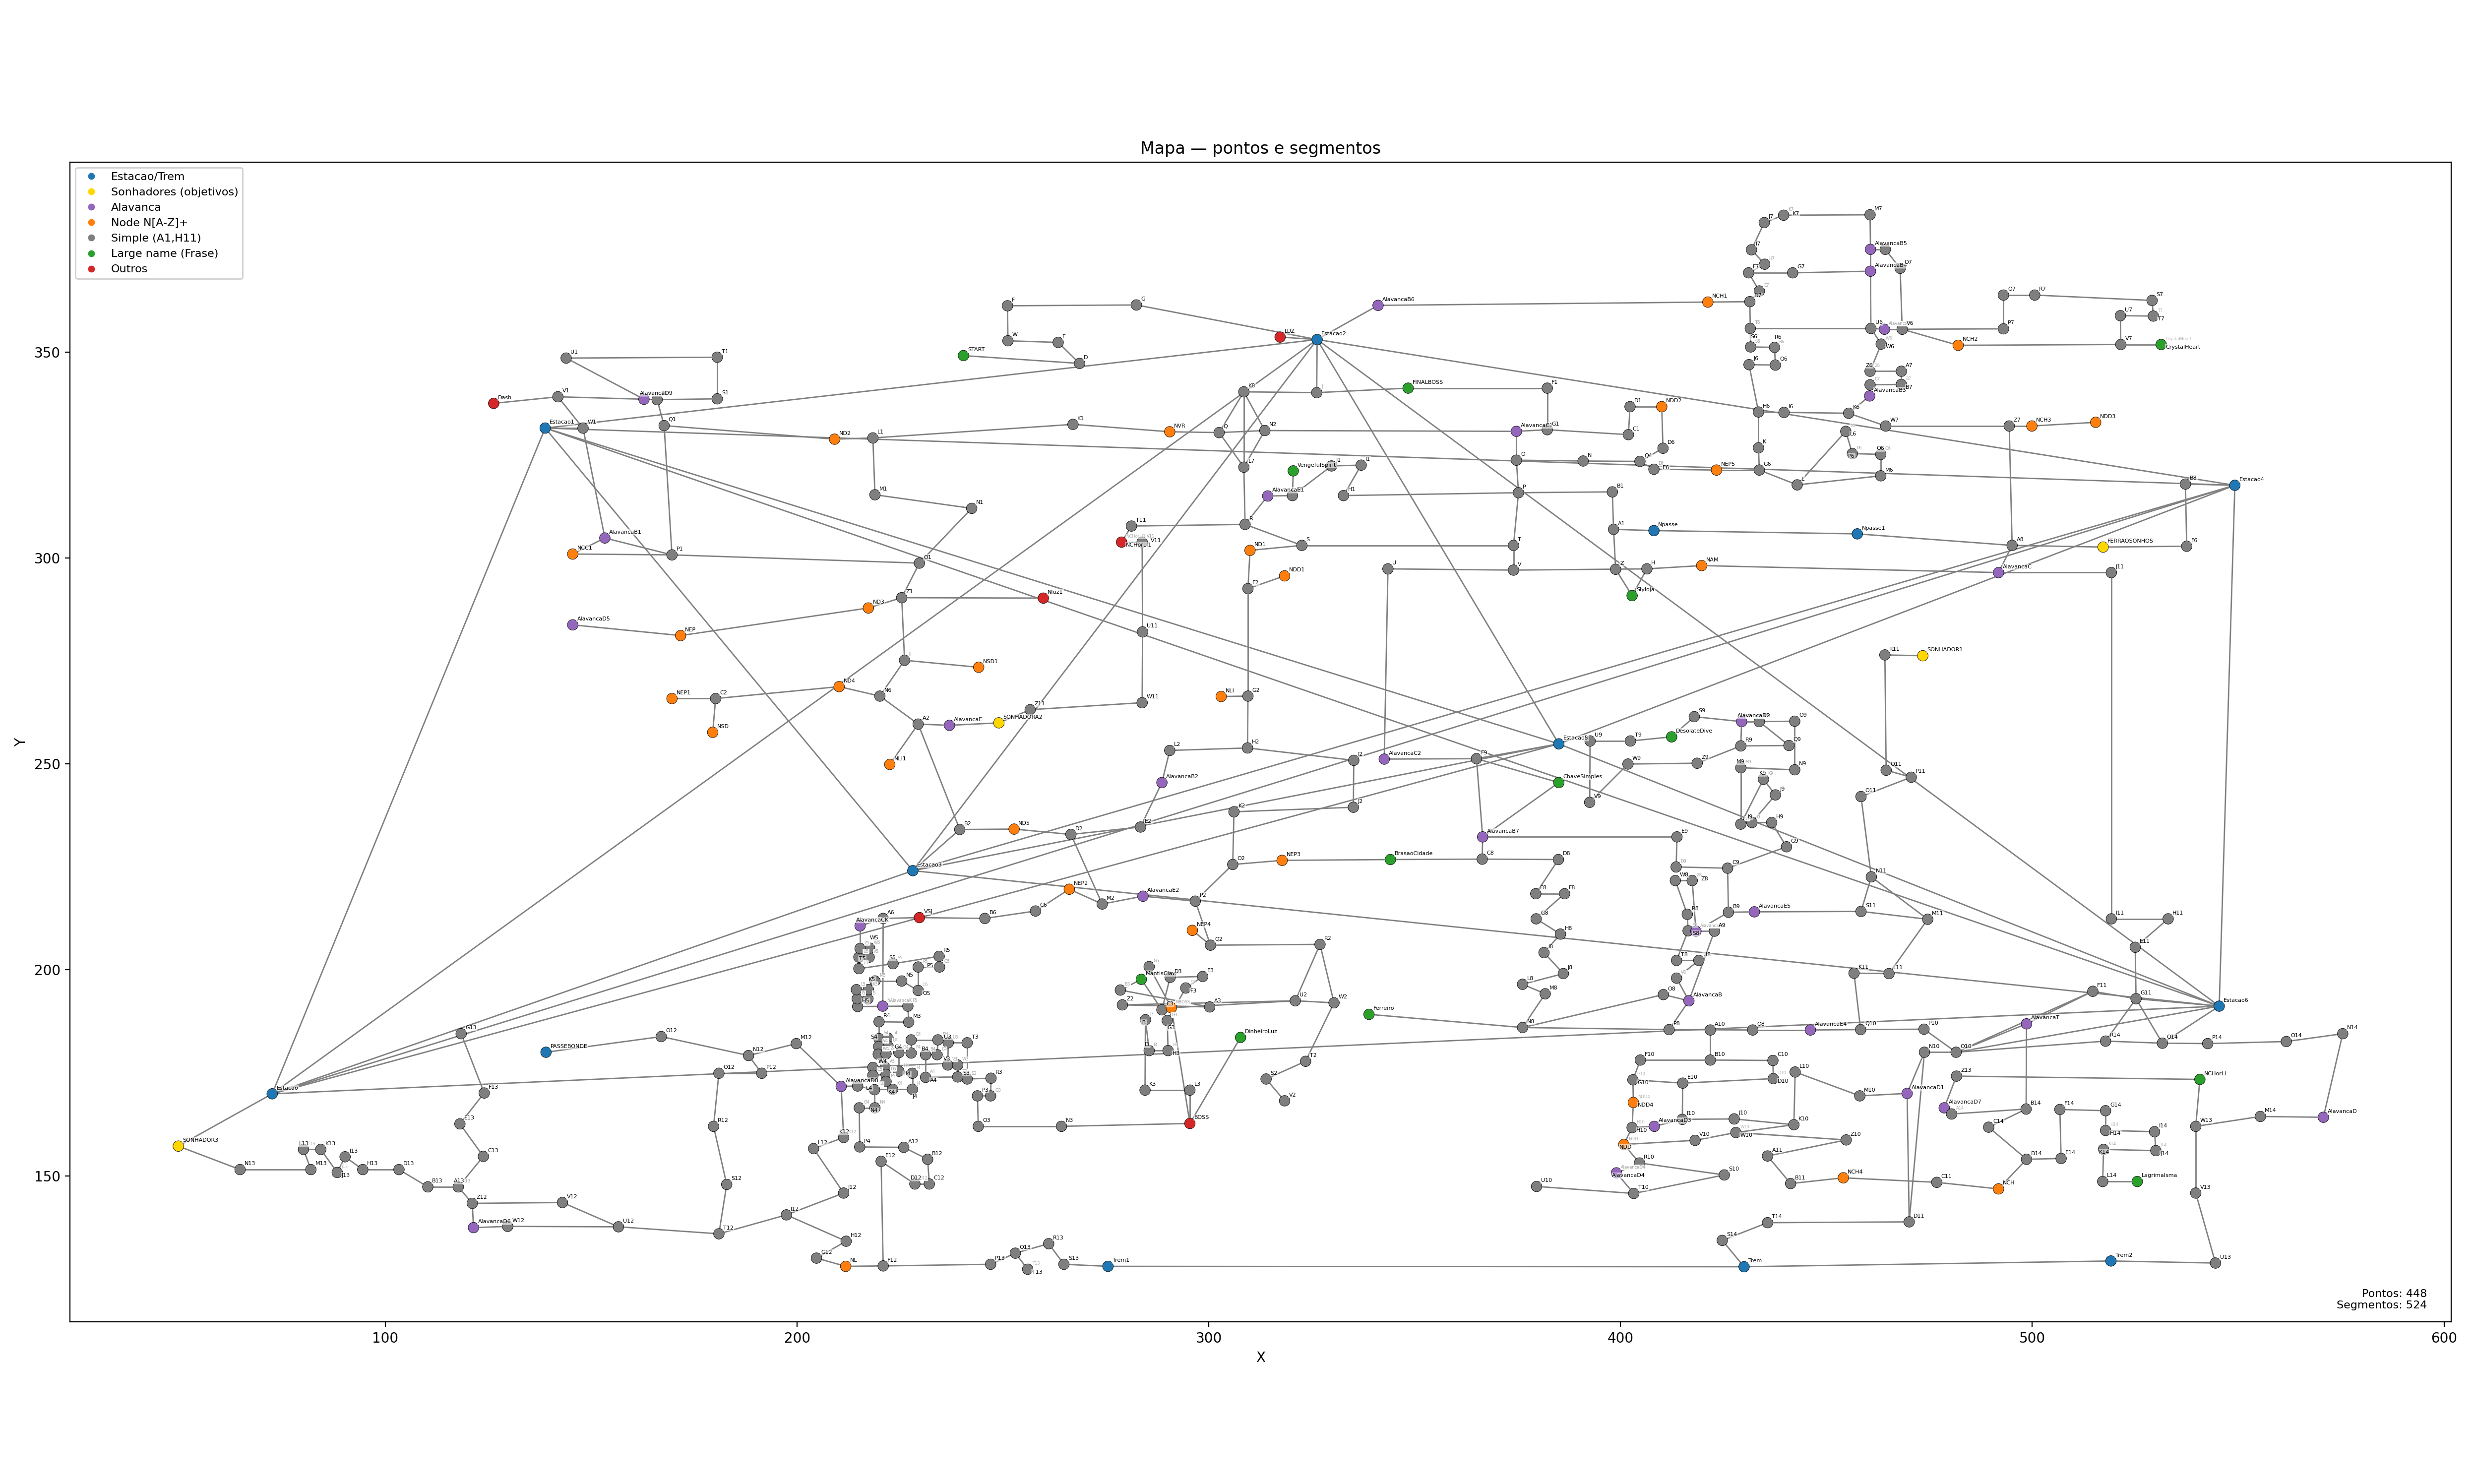

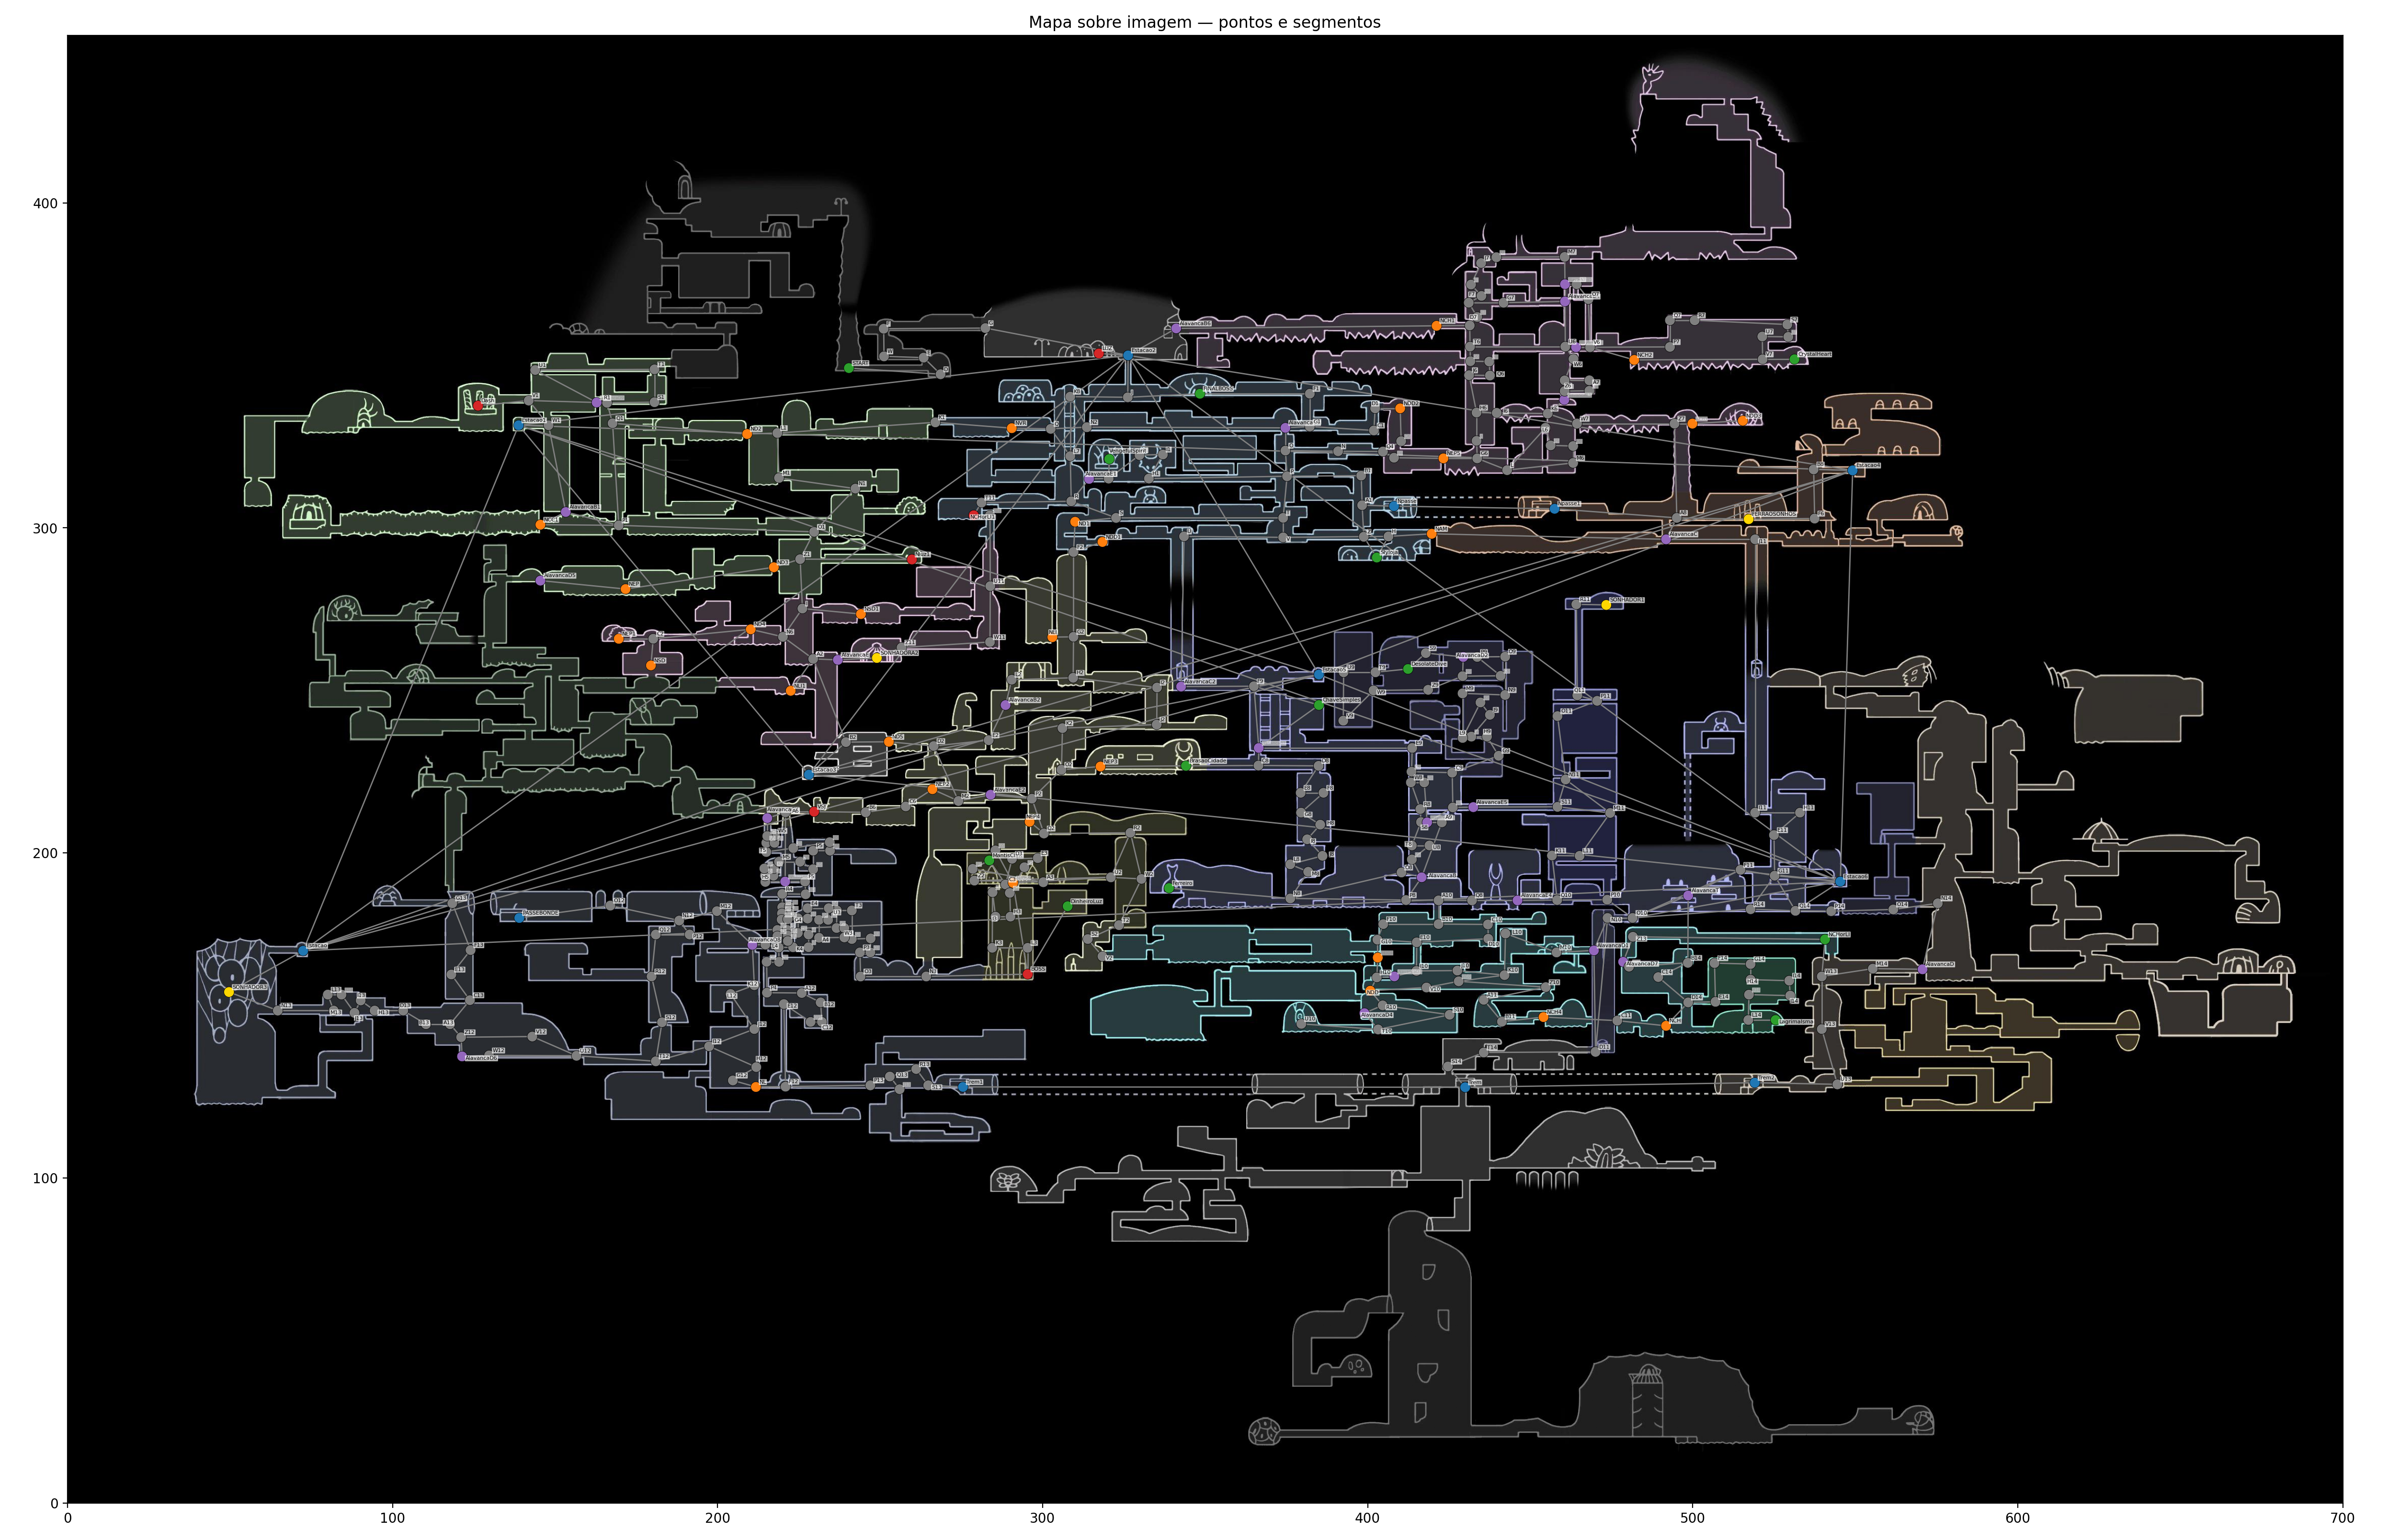

In [92]:
# Visualização do grafo com Matplotlib

BASE = Path.cwd()  # diretório atual do notebook
PONTOS_CSV = BASE / "pontos.csv"
SEGMENTOS_CSV = BASE / "segmentos.csv"
OUT_PNG = BASE / "mapa_plot.png"

if not PONTOS_CSV.exists() or not SEGMENTOS_CSV.exists():
    print('Arquivos `pontos.csv` ou `segmentos.csv` não encontrados no diretório:', BASE)
    raise SystemExit(1)

# lê pontos
points = {}
with PONTOS_CSV.open('r', encoding='utf-8', newline='') as f:
    reader = csv.DictReader(f)
    for row in reader:
        name = row.get('name','').strip()
        x = row.get('x','').strip()
        y = row.get('y','').strip()
        try:
            xf = float(x)
            yf = float(y)
            points[name] = (xf, yf)
        except Exception:
            # ignora pontos sem coords válidas
            continue

# lê segmentos
segments = []
missing_points = set()
with SEGMENTOS_CSV.open('r', encoding='utf-8', newline='') as f:
    reader = csv.DictReader(f)
    for row in reader:
        name = row.get('name','').strip()
        start = row.get('start','').strip()
        end = row.get('end','').strip()
        length = row.get('length','').strip()
        # store
        segments.append({'name': name, 'start': start, 'end': end, 'length': length})
        if start not in points:
            missing_points.add(start)
        if end not in points:
            missing_points.add(end)

# Prepara plot
xs = [c[0] for c in points.values()]
ys = [c[1] for c in points.values()]

if xs and ys:
    minx, maxx = min(xs), max(xs)
    miny, maxy = min(ys), max(ys)
else:
    minx = miny = 0
    maxx = maxy = 1

# margin
dx = maxx - minx if maxx > minx else 1.0
dy = maxy - miny if maxy > miny else 1.0
margin = 0.05
padx = dx * margin
pady = dy * margin

fig_w = 10
# adapt figure size to aspect and to number of points (wider when many points)
num_points = max(1, len(points))
density_scale = min(3.0, 1.0 + (num_points / 300.0))
fig_h = max(6, (dy/dx) * fig_w) if dx > 0 else fig_w
fig = plt.figure(figsize=(fig_w * density_scale, fig_h * density_scale))
ax = fig.add_subplot(1,1,1)

# Draw segments first (so points/labels are on top)
for seg in segments:
    s = seg['start']
    e = seg['end']
    if s in points and e in points:
        x1,y1 = points[s]
        x2,y2 = points[e]
        ax.plot([x1,x2],[y1,y2], color='gray', linewidth=1, zorder=1)
    else:
        # skip drawing if missing
        continue

# Draw points
px = []
py = []
plabels = []
pcolors = []
def point_color(name: str) -> str:
    n = (name or '').strip()
    nl = n.lower()
    # Stations / trains -> blue (explicit)
    if 'estacao' in nl or 'trem' in nl or 'passe' in nl:
        return 'tab:blue'
    # Sonhadores (objetivos) -> gold (very special)
    if re.search(r'(?i)sonh', n):
        return 'gold'
    # Alavancas (contains 'Alavanca') -> purple
    if re.search(r'(?i)alavanc', n):
        return 'tab:purple'
    # Nodes that require a power: start with literal N followed by letters (e.g. NLL, NL, NVR)
    if re.match(r'^N[A-Z]+[0-9]*$', n):
        return 'tab:orange'
    # Simple nodes: only letters or letters followed by digits (A1, H11, K8)
    if re.match(r'^[A-Za-z]([0-9]+)?$', n):
        return 'tab:gray'
    # Big named things (single word, mostly letters, length >=5) -> highlight
    if len(n) >= 5 and re.match(r'^[A-Za-z]+$', n):
        return 'tab:green'
    # fallback: other special names
    return 'tab:red'
for name,(x,y) in points.items():
    px.append(x)
    py.append(y)
    plabels.append(name)
    pcolors.append(point_color(name))
# Compute a sensible marker size based on map scale and point density
try:
    # estimate closest neighbor distance (O(n^2) but n is moderate here)
    min_dist = None
    coords = list(points.values())
    n = len(coords)
    for i in range(n):
        x1,y1 = coords[i]
        for j in range(i+1, n):
            x2,y2 = coords[j]
            d = math.hypot(x2-x1, y2-y1)
            if d == 0:
                continue
            if min_dist is None or d < min_dist:
                min_dist = d
    if not min_dist or min_dist <= 0:
        min_dist = max(dx, dy) * 0.005
except Exception:
    min_dist = max(dx, dy) * 0.005

# marker size in points^2 (approx); inversely proportional to density
marker_size = max(6, min(60, (min(dx,dy) / (min_dist + 1e-9)) * 3))
ax.scatter(px, py, c=pcolors, s=marker_size, edgecolor='k', linewidth=0.3, zorder=2)

# Annotate all labels but scale font size and offset according to local density
x_range = maxx - minx if maxx>minx else 1.0
y_range = maxy - miny if maxy>miny else 1.0

# base offset: fraction of min distance between points
base_off = min_dist * 0.25
# ensure a minimum offset in data units
min_off = max(x_range, y_range) * 0.002
off = max(base_off, min_off)

# font sizing: smaller fonts when many points close together
font_size = max(4, min(10, int(8 * (min_dist / (max(dx, dy) * 0.05) + 0.2))))

# Place labels with a simple collision-avoidance heuristic:
# try a series of offsets and pick the first that doesn't collide with
# previously placed labels (measured by distance in data coordinates).
placed_labels = []  # list of (lx,ly) label anchor positions
label_sep = max(min_dist * 0.6, max(x_range, y_range) * 0.01)
offset_options = [
    (off, off), (off, -off), (-off, off), (-off, -off),
    (2*off, 0), (0, 2*off), (-2*off, 0), (0, -2*off)
]

for name, (x, y) in points.items():
    placed = False
    for dx_off, dy_off in offset_options:
        lx = x + dx_off
        ly = y + dy_off
        collision = False
        for px_l, py_l in placed_labels:
            if math.hypot(lx - px_l, ly - py_l) < label_sep:
                collision = True
                break
        if not collision:
            ax.annotate(name, (lx, ly), fontsize=font_size,
                        bbox=dict(boxstyle='round,pad=0.12', facecolor='white', alpha=0.6, edgecolor='none'),
                        zorder=3)
            placed_labels.append((lx, ly))
            placed = True
            break
        if not placed:
            # as a last resort, place with very small font and lower opacity to avoid clutter
            ax.annotate(name, (x + off, y + off), fontsize=max(3, font_size - 2),
                        color='gray', alpha=0.6,
                        bbox=dict(boxstyle='round,pad=0.08', facecolor='white', alpha=0.6, edgecolor='none'),
                        zorder=2)

ax.set_xlim(minx - padx, maxx + padx)
ax.set_ylim(miny - pady, maxy + pady)
ax.set_aspect('equal', adjustable='box')
ax.set_title('Mapa — pontos e segmentos')
ax.set_xlabel('X')
ax.set_ylabel('Y')

# Legend with counts
ax.text(0.99, 0.01, f'Pontos: {len(points)}\nSegmentos: {len(segments)}',
        transform=ax.transAxes, ha='right', va='bottom', fontsize=8,
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# color legend for point types
legend_handles = [
    Line2D([0], [0], marker='o', color='w', label='Estacao/Trem', markerfacecolor='tab:blue', markersize=6),
    Line2D([0], [0], marker='o', color='w', label='Sonhadores (objetivos)', markerfacecolor='gold', markersize=6),
    Line2D([0], [0], marker='o', color='w', label='Alavanca', markerfacecolor='tab:purple', markersize=6),
    Line2D([0], [0], marker='o', color='w', label='Node N[A-Z]+', markerfacecolor='tab:orange', markersize=6),
    Line2D([0], [0], marker='o', color='w', label='Simple (A1,H11)', markerfacecolor='tab:gray', markersize=6),
    Line2D([0], [0], marker='o', color='w', label='Large name (Frase)', markerfacecolor='tab:green', markersize=6),
    Line2D([0], [0], marker='o', color='w', label='Outros', markerfacecolor='tab:red', markersize=6),
]
ax.legend(handles=legend_handles, loc='upper left', fontsize=8, framealpha=0.9)

# Save
fig.tight_layout()
fig.savefig(OUT_PNG, dpi=200)
print('Imagem salva em:', OUT_PNG)
print('Pontos lidos:', len(points))
print('Segmentos lidos:', len(segments))
if any(missing_points):
    # remove empty names
    missing = sorted([m for m in missing_points if m])
    print('Aviso: os seguintes nomes referenciados em segmentos não foram encontrados em pontos.csv:')
    for m in missing[:50]:
        print(' -', m)
    if len(missing) > 50:
        print(' ... e mais', len(missing)-50, 'itens')
else:
    print('Todos os pontos referenciados em segmentos foram encontrados.')

print('Pronto.')

# Second plot: overlay points on background image (image.png)
IMG_PATH = BASE / "mapa.png"
OUT_PNG_BG = BASE / "mapa_plot_bg.png"

if IMG_PATH.exists():
    try:
        img = mpimg.imread(str(IMG_PATH))
        # flip the image vertically so it displays right-side-up on the plot
        try:
            img = np.flipud(img)
        except Exception:
            # if flip fails (e.g., unexpected array shape), fall back to original
            pass
        ih, iw = img.shape[0], img.shape[1]
        # map image width to x in [0,700]; scale y accordingly
        scale = 700.0 / float(iw)
        img_height_scaled = ih * scale

        fig2_w = max(10, fig_w * density_scale)
        fig2_h = max(6, (img_height_scaled / 700.0) * fig2_w)
        fig2 = plt.figure(figsize=(fig2_w, fig2_h))
        ax2 = fig2.add_subplot(1,1,1)

        # show image with origin at lower so (0,0) is bottom-left
        ax2.imshow(img, extent=[0, 700, 0, img_height_scaled], origin='lower')

        # draw segments on top (plot using image coords: bottom-left = (0,0))
        for seg in segments:
            s = seg['start']
            e = seg['end']
            if s in points and e in points:
                x1,y1 = points[s]
                x2,y2 = points[e]
                ax2.plot([x1,x2],[y1,y2], color='gray', linewidth=1, zorder=2)

        # draw points
        # use point coordinates directly (image origin is set to lower so (0,0) is bottom-left)
        px2 = [c[0] for c in points.values()]
        py2 = [c[1] for c in points.values()]
        # adapt marker size for image plot
        marker_size2 = marker_size
        # build color list for image overlay in same order as points.values()
        pkeys = list(points.keys())
        colors2 = [point_color(k) for k in pkeys]
        ax2.scatter(px2, py2, c=colors2, s=marker_size2, edgecolor='k', linewidth=0.3, zorder=3)

        # place labels using same heuristic but constrained to image extent
        placed_labels = []
        label_sep = max(min_dist * 0.6, max(700.0, img_height_scaled) * 0.01)
        offset_options = [
            (off, off), (off, -off), (-off, off), (-off, -off),
            (2*off, 0), (0, 2*off), (-2*off, 0), (0, -2*off)
        ]
        for name, (x, y) in points.items():
            placed = False
            for dx_off, dy_off in offset_options:
                # compute candidate label position in image coords
                lx = x + dx_off
                ly = y + dy_off
                # ensure label anchor inside image bounds
                if lx < 0 or lx > 700 or ly < 0 or ly > img_height_scaled:
                    continue
                collision = False
                for px_l, py_l in placed_labels:
                    if math.hypot(lx - px_l, ly - py_l) < label_sep:
                        collision = True
                        break
                if not collision:
                    ax2.annotate(name, (lx, ly), fontsize=font_size,
                                     bbox=dict(boxstyle='round,pad=0.10', facecolor='white', alpha=0.7, edgecolor='none'),
                                     zorder=4)
                    placed_labels.append((lx, ly))
                    placed = True
                    break
            if not placed:
                ax2.annotate(name, (x + off, y + off), fontsize=max(3, font_size - 2),
                             color='gray', alpha=0.6,
                             bbox=dict(boxstyle='round,pad=0.08', facecolor='white', alpha=0.6, edgecolor='none'),
                             zorder=3)

        ax2.set_xlim(0, 700)
        ax2.set_ylim(0, img_height_scaled)
        ax2.set_aspect('equal', adjustable='box')
        ax2.set_title('Mapa sobre imagem — pontos e segmentos')

        fig2.tight_layout()
        fig2.savefig(OUT_PNG_BG, dpi=200)
        print('Imagem com fundo salva em:', OUT_PNG_BG)
        plt.close(fig2)
    except Exception as exc:
        print('Falha ao gerar imagem com fundo:', exc)
else:
    print('Arquivo de imagem `image.png` não encontrado em:', IMG_PATH)


display(Image(filename=str(Path.cwd() / "mapa_plot.png")))
display(Image(filename=str(Path.cwd() / "mapa_plot_bg.png")))
plt.close(fig)

## 2. Construção do grafo dirigido

Cada ponto será um nó e cada segmento será uma aresta com comprimento associado.


In [93]:
import networkx as nx

# 2. Construção do grafo dirigido com NetworkX
G = nx.DiGraph()


# Supondo que pontos.csv tenha uma coluna 'name' para identificar os nós
node_col = "name" if "name" in pontos_df.columns else pontos_df.columns[0]

for _, row in pontos_df.iterrows():
    node = row[node_col]
    G.add_node(node, **row.to_dict())

# Supondo que segmentos.csv tenha colunas 'start', 'end' e 'length'
start_col = "start"
end_col = "end"
length_col = "length"


for _, row in segmentos_df.iterrows():
    i = row[start_col]
    j = row[end_col]
    length = float(row[length_col])
    G.add_edge(i, j, **row.to_dict())



print("Nós:", len(G.nodes))
print("Arestas:", len(G.edges))

Nós: 448
Arestas: 523


## 3. Definição dos poderes, requisitos e parâmetros do problema

Aqui definimos quais nós representam poderes, quais poderes são obrigatórios e quais arestas exigem certos poderes para serem percorridas.


In [94]:
# 3. Definição dos poderes, requisitos e parâmetros do problema



# Nó de origem (início da run) e nó de destino (zerar o jogo)

# ATENÇÃO: ajuste estes nomes para bater com os nós do seu CSV

origin = list(G.nodes)[0]        # por enquanto, pega o primeiro nó como exemplo

destination = list(G.nodes)[-1]  # último nó como exemplo

print("Origem:", origin, "Destino:", destination)



# Definição manual (por enquanto) dos poderes e onde são obtidos

# Substitua pelos poderes reais e nós correspondentes do seu grafo

node_power = {

    # Exemplo:

    # "MANTIS_CLAW": "MantisVillage",

    # "MONARCH_WINGS": "AncientBasin",

}



# Conjunto de poderes obrigatórios para zerar o jogo

required_powers = set([

    # "MANTIS_CLAW",

])



powers = set(node_power.keys())

print("Poderes definidos:", powers)

print("Poderes obrigatórios:", required_powers)



# Requisitos de poder em cada arco: power_requirements[(i,j)] = conjunto de poderes necessários

power_requirements = {}

for (i, j) in G.edges():

    power_requirements[(i, j)] = set()



# Exemplo de como adicionar um requisito de poder em uma aresta específica (ajuste depois):

# power_requirements[("AlgumNoA", "AlgumNoB")] = {"MANTIS_CLAW"}



print("Total de arestas com requisitos cadastrados:", sum(1 for req in power_requirements.values() if len(req) > 0))

Origem: START Destino: T14
Poderes definidos: set()
Poderes obrigatórios: set()
Total de arestas com requisitos cadastrados: 0


## 4. Preparação dos conjuntos e do modelo de otimização (Pyomo)

Formulamos um modelo de caminho mínimo com poderes:

- `x[i,j]` indica se usamos a aresta `(i,j)`;

- `y[n,k]` indica se ao chegar em `n` já temos o poder `k`;

- `z[k]` indica se o poder `k` é obtido em algum momento da rota.


In [95]:
# 4. Preparação de conjuntos e parâmetros



nodes = list(G.nodes())

arcs = list(G.edges())



# Distância de cada arco

dist = {(i, j): float(G[i][j].get("length", 1.0)) for (i, j) in arcs}



# Vizinhanças (úteis para restrições de fluxo)

out_arcs = {i: [] for i in nodes}

in_arcs = {i: [] for i in nodes}

for (i, j) in arcs:

    out_arcs[i].append(j)

    in_arcs[j].append(i)



print("Nós:", len(nodes), "Arestas:", len(arcs))

Nós: 448 Arestas: 523


In [96]:
# 4b. Criação do modelo Pyomo



model = pyo.ConcreteModel()



# Conjuntos

model.N = pyo.Set(initialize=nodes)

model.A = pyo.Set(initialize=arcs, dimen=2)

model.K = pyo.Set(initialize=list(powers))  # poderes



# Parâmetro de distância

model.dist = pyo.Param(model.A, initialize=dist, within=pyo.NonNegativeReals)



# Variáveis

# x[i,j] = 1 se arco (i,j) é usado

model.x = pyo.Var(model.A, within=pyo.Binary)



# y[n,k] = 1 se ao chegar em n já temos o poder k

model.y = pyo.Var(model.N, model.K, within=pyo.Binary)



# z[k] = 1 se o poder k é obtido em algum momento

model.z = pyo.Var(model.K, within=pyo.Binary)

## 5. Restrições do modelo

Incluímos:

- conservação de fluxo (caminho simples de origem a destino);

- consistência dos poderes ao longo do caminho;

- uso de uma aresta só se os poderes necessários já foram obtidos;

- garantia de obtenção de poderes obrigatórios.


In [97]:
# 5a. Conservação de fluxo (caminho de origin até destination)



def fluxo_rule(model, n):

    out_flow = sum(model.x[n, j] for j in out_arcs.get(n, []) if (n, j) in model.A)

    in_flow = sum(model.x[i, n] for i in in_arcs.get(n, []) if (i, n) in model.A)

    if n == origin:

        return out_flow - in_flow == 1

    elif n == destination:

        return in_flow - out_flow == 1

    else:

        return out_flow - in_flow == 0



model.con_fluxo = pyo.Constraint(model.N, rule=fluxo_rule)



# 5b. Propagação dos poderes ao longo do caminho

# Ideia: se passamos por um nó onde o poder k é obtido, podemos "ativá-lo"; depois, ele permanece disponível.



# Pré-processar nó de obtenção de cada poder

power_node = node_power  # só renomeando para clareza



def poder_inicial_rule(model, n, k):

    # Antes de pegar o poder k, não o temos em nenhum nó; depois do nó de poder, podemos passar a tê-lo.

    # Modelo simples: em qualquer nó, y[n,k] <= z[k]

    return model.y[n, k] <= model.z[k]



model.con_poder_inicial = pyo.Constraint(model.N, model.K, rule=poder_inicial_rule)



def poder_obtido_em_no_rule(model, k):

    n_k = power_node[k]

    # Se o poder k é obtido, então em n_k devemos ter y[n_k, k] = 1;

    # e n_k precisa ser visitado (alguma aresta entra ou sai).

    in_use = sum(model.x[i, n_k] for i in in_arcs.get(n_k, []) if (i, n_k) in model.A)

    out_use = sum(model.x[n_k, j] for j in out_arcs.get(n_k, []) if (n_k, j) in model.A)

    return model.y[n_k, k] >= model.z[k] - (1 - (in_use + out_use))



# Esta restrição é um pouco forte; para evitar não linearidade, simplificamos:

# se z[k] = 1, forçamos visitar o nó do poder:



def visita_no_poder_rule(model, k):

    n_k = power_node[k]

    in_use = sum(model.x[i, n_k] for i in in_arcs.get(n_k, []) if (i, n_k) in model.A)

    out_use = sum(model.x[n_k, j] for j in out_arcs.get(n_k, []) if (n_k, j) in model.A)

    return in_use + out_use >= model.z[k]



model.con_visita_no_poder = pyo.Constraint(model.K, rule=visita_no_poder_rule)



# 5c. Poderes obrigatórios devem ser obtidos: z[k] = 1 para k obrigatório

def obrigatorio_rule(model, k):

    if k in required_powers:

        return model.z[k] == 1

    return pyo.Constraint.Skip



model.con_poderes_obrigatorios = pyo.Constraint(model.K, rule=obrigatorio_rule)



# 5d. Uso de aresta só se todos poderes exigidos já foram obtidos no nó de saída



def poder_para_aresta_rule(model, i, j):

    req = power_requirements.get((i, j), set())

    if not req:

        return pyo.Constraint.Skip

    # Para cada poder k exigido, se x[i,j] = 1 então y[i,k] = 1

    return sum(model.y[i, k] for k in req) >= len(req) * model.x[i, j]



model.con_requisitos_aresta = pyo.Constraint(model.A, rule=poder_para_aresta_rule)

## 6. Função objetivo e solução do modelo

Minimizamos a soma das distâncias das arestas usadas.


In [98]:
# 6a. Função objetivo



def obj_rule(model):

    return sum(model.dist[i, j] * model.x[i, j] for (i, j) in model.A)



model.obj = pyo.Objective(rule=obj_rule, sense=pyo.minimize)



# 6b. Resolver o modelo (usando o solver CBC, GLPK, etc.)

# Ajuste o nome do solver para um que você tenha instalado



solver = pyo.SolverFactory("cbc")  # ou "glpk", "gurobi", etc.

results = solver.solve(model, tee=True)



print(results)

cbc


ApplicationError: No executable found for solver 'cbc'